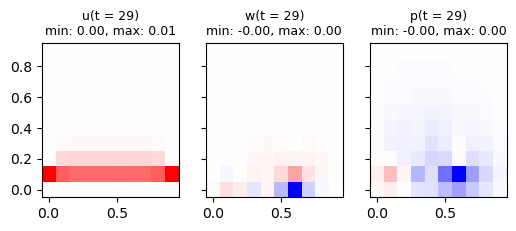

In [4]:
import numpy as np, xarray as xr
import matplotlib, matplotlib.pyplot as plt

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

def QUICK_ddx_GR(data, dx):
    """
    Compute the first derivative using the QUICK scheme.
    axis=1 for x-direction (columns), axis=0 for z-direction (rows)
    """
    
    ddx = np.zeros_like(data)
    # Iterate over rows: index from 1 to -1 to avoid edges
    for i in range(1, ddx.shape[0]-1):
        # Iterate over columns: index from 1 to -1 to avoid edges
        for j in range(1, ddx.shape[1]-1):
            # If index sufficient, use QUICK
            if j > 1:
                # Follow Veldman, Eq. 1.15
                # Consider d_dx per QUICK to be d_dx = A + B + C
                A = (data[i, j+1] - data[i, j-1])/(2*dx)
                B = (data[i, j+1] - 3*data[i, j] + 3*data[i, j-1] - data[i, j-2])/(8*dx)
                C = dx**2*(1/8 - 1/6)*(data[i, j+1] - 3*data[i, j] + 3*data[i, j-1] - data[i, j-2])/dx**3
                ddx[i, j] = A + B + C
            # Else, revert to CDF2
            else:
                ddx[i, j] = (data[i, j+1] - data[i, j-1])/(2*dx)
                
    return ddx

def QUICK_ddz_GR(data, dz):
    """
    Compute the first derivative using the QUICK scheme.
    axis=1 for x-direction (columns), axis=0 for z-direction (rows)
    """
    
    ddz = np.zeros_like(data)
    # Iterate over rows: index from 1 to -1 to avoid edges
    for i in range(1, ddz.shape[0]-1):
        # Iterate over columns: index from 1 to -1 to avoid edges
        for j in range(1, ddz.shape[1]-1):
            # If index sufficient, use QUICK
            if i > 1:
                # Follow Veldman, Eq. 1.15
                # Consider d_dx per QUICK to be d_dx = A + B + C
                A = (data[i+1, j] - data[i-1, j])/(2*dz)
                B = (data[i+1, j] - 3*data[i, j] + 3*data[i-1, j] - data[i-2, j])/(8*dz)
                C = dx**2*(1/8 - 1/6)*(data[i+1, j] - 3*data[i, j] + 3*data[i-1, j] - data[i-2, j])/dz**3
                ddz[i, j] = A + B + C
            # Else, revert to CDF2
            else:
                ddz[i, j] = (data[i+1, j] - data[i-1, j])/(2*dz)
                
    return ddz
                
def quick_first_derivative(data, dx, axis=1):
    """
    Compute the first derivative using the QUICK scheme.
    axis=1 for x-direction (columns), axis=0 for z-direction (rows)
    """
    if axis == 1:
        # Pad only along the x-direction
        padded_data = np.pad(data, pad_width=((0, 0), (3, 3)), mode='edge')
        derivative = (3/8 * padded_data[:, 3:-3] - 6/8 * padded_data[:, 4:-2] +
                      6/8 * padded_data[:, 5:-1] - 1/8 * padded_data[:, 6:]) / dx
    elif axis == 0:
        # Pad only along the z-direction
        padded_data = np.pad(data, pad_width=((3, 3), (0, 0)), mode='edge')
        derivative = (3/8 * padded_data[3:-3, :] - 6/8 * padded_data[4:-2, :] +
                      6/8 * padded_data[5:-1, :] - 1/8 * padded_data[6:, :]) / dx
    return derivative

def quick_derivative(data, axis, dx):
    # Assuming data is a 2D array and axis is the dimension along which to take the derivative
    d_data = np.zeros_like(data)
    if axis == 0:  # derivative along x
        for i in range(1, data.shape[0]-1):
            d_data[i, :-3] = (1/8 * data[i, :-3] - 7/8 * data[i, 1:-2] + 7/8 * data[i, 2:-1] - 1/8 * data[i, 3:]) / dx
    elif axis == 1:  # derivative along z
        for j in range(1, data.shape[1]-1):
            d_data[:-3, j] = (1/8 * data[:-3, j] - 7/8 * data[1:-2, j] + 7/8 * data[2:-1, j] - 1/8 * data[3:, j]) / dx
    return d_data

def func_d2x(data, dx):
    ''' 
    Second partial derivative with respect to z. (d_dz)
    Use second-order central difference. 
    '''
    
    # Initialize container array
    d2dx = np.full(shape=data.shape, fill_value=0, dtype=float)
    # Iterate over each row
    for i in range(1, len(data['z'])-1):
        for j in range(1, len(data['x'])-1):
            d2dx[i, j] = (data.isel(z=i, x=j+1) - 2*data.isel(z=i, x=j) +  data.isel(z=i, x=j-1))/(dx**2)
    
    return d2dx

def func_d2z(data, dz):
    ''' 
    Partial derivative with respect to z. (d_dz)
    Use second-order central difference. 
    '''
    
    # Initialize container array
    d2dz = np.full(shape=data.shape, fill_value=0, dtype=float)
    # Iterate over each row
    for i in range(1, len(data['z'])-1):
        for j in range(1, len(data['x'])-1):
            d2dz[i, j] = (data.isel(z=i+1, x=j) - 2*data.isel(z=i, x=j) + data.isel(z=i-1, x=j))/(dz**2)

    return d2dz

def init(N, dt=0.01, rho_0=1, time_max=10):
    # Define number of grid point
    N_x, N_z = N, N
    # Define the bounds for the domain
    bounds_x, bounds_z = [0, 1], [0, 1]
    # Define grid spacing
    dx = (max(bounds_x) - min(bounds_x))/N_x
    dz = (max(bounds_z) - min(bounds_x))/N_z
    # Define time axis
    time = range(0, time_max)

    # Define the basis vector (x-axis, z-axis)
    x, z = [np.arange(min(bounds_z), max(bounds_x), dx),
            np.arange(min(bounds_z), max(bounds_z), dz)]
    # Crete meshgrid
    X, Z = np.meshgrid(x, z)

    ''' Initial values '''
    # Density
    rho_init = np.full(shape=X.shape, fill_value=rho_0)
    rho = np.full(shape=(len(time), X.shape[0], X.shape[1]), fill_value=np.nan)
    rho[0, :, :] = rho_init
    # Pressure
    p_init = 0
    p = np.full(shape=(len(time), X.shape[0], X.shape[1]), fill_value=np.nan)
    p[0, :, :] = p_init

    # Horizontal velocity
    u_init = np.full(shape=(len(time), X.shape[0], X.shape[1]), fill_value=0, dtype=float)
    u_init[0, 1, :] = .01

    # Vertical velocity
    w_init = np.full(shape=(len(time), X.shape[0], X.shape[1]), fill_value=0, dtype=float)

    # Build and populate xArray Dataset
    data = xr.Dataset(coords={'x': (['x'], x), 'z': (['z'], z),'t': (['t'], time)},
                      data_vars={'p': (['t', 'z', 'x'], p, {'long_name': 'pressure', 'units': 'Pa'}),
                                 'rho': (['t', 'z', 'x',], rho, {'long_name': 'density', 'units': 'kg m^{-3}'})})
    data['u'] = (['t', 'z', 'x'], u_init, {'long_name': 'horizontal velocity', 'units': 'm s^{-1}'})
    data['w'] = (['t', 'z', 'x'], w_init, {'long_name': 'vertical velocity', 'units': 'm s^{-1}'})
    return N, x, z, dx, dz, data

def direct_inversion_QUICK(data, N, time_index, dx, dz, dt):
    
    '''
    Direct inversion for a linear matrix system, Ap = b.
    A is an M x M matrix (M = N_x * N_z), b is an M-sized vector. We're solving for pressure (p).
    '''

    # Initialize Jacobian
    M = N
    A = np.identity(M**2, dtype=float) # 5-point stencil
    b = np.full(shape=M**2, fill_value=0, dtype=float) # Equals the right-hand side of the differential (commonly called f)
    # Grab static version of the relevant fields
 
    p = data['p'].isel(t=time_index).copy()
    u = data['u'].isel(t=time_index).values
    w = data['w'].isel(t=time_index).values
    divergence_u = quick_derivative(u, 0, dx)
    divergence_w = quick_derivative(w, 1, dz)
    divergence = divergence_u + divergence_w
    
    divergence_u = quick_derivative(u, 0, dx)
    divergence_w = quick_derivative(w, 1, dz)
    divergence = divergence_u + divergence_w
    
    row = 0
    # Iterate over each point (each point corresponds to a row in matrix A)
    for i in range(0, N): # iterate over rows
        for j in range(0, N): # iterate over columns
            # print('Row: {0}; M: {1}, row % M: {2}'.format(row, M, row % M))
            # print('\t Calculating at point: ({0}, {1}); Jacobian row: {2}'.format(i, j, row))
            # print('\t \t u-coords: i-1: {0}; i+1: {1}; j-1: {2}; j+1: {3}'.format((i-1), (i+1), (j-1), (j+1)))
            # print('\t \t M-coords: i-1 (ym): {0}; i+1 (yp): {1}; j-1 (xm): {2}; j+1 (xp): {3}'.format(row-M, row+M, row-1, row+1))
          
            # Capture the iterand values
            
            # Fill in identity diagonal
            A[row, row] = -4
            # Get indices for +/- x and y values
            ym, yp, xm, xp = row - M, row + M, row - 1, row + 1
            
            ''' Set boundary conditions. '''
                
            # Handle corners
            # Top left
            if (row // M == 0) and (row % M == 0):
                # print('Top left')
                A[xp, row] = 1
                A[yp, row] = 1
                b[row] = 0 + p[i, j] # Dirichlet top, Neumann left BC
            # Top right
            elif (row // M == 0) and ((row % M) == (M-1)):
                # print('Top right')
                A[xm, row] = 1
                A[yp, row] = 1
                b[row] = 0 + p[i, j] # Dirichlet top, Neumann right BC
            # Bottom left
            elif (row // M == (M-1)) and (row % M == 0):
                # print('Bottom left')
                A[xp, row] = 1
                A[ym, row] = 1
                b[row] = p[i, j] + p[i, j] # Neumann bottom BC, Neumann left BC
            # Bottom right
            elif (row // M == (M-1)) and ((row % M) == (M-1)):
                # print('Bottom right')
                A[xm, row] = 1
                A[ym, row] = 1
                b[row] = p[i, j] + p[i, j] # Neumann bottom BC, Neumann right BC
            # Top center
            elif (row // M == 0) and ((row % M != 0) and ((row % M) != (M-1))):
                # print('Top center')
                A[xm, row] = 1
                A[xp, row] = 1
                A[yp, row] = 1
                b[row] = 0 # Dirichlet top BC
            # Bottom center
            elif (row // M == (M-1)) and ((row % M != 0) and ((row % M) != (M-1))):
                # print('Bottom center')
                A[xm, row] = 1
                A[xp, row] = 1
                A[ym, row] = 1
                b[row] = p[i, j] # Neumann bottom BC
            # Left center
            elif (row % M == 0) and ((row // M != 0) and (row // M != (M-1))):
                # print('Left center')
                A[xp, row] = 1
                A[ym, row] = 1
                A[yp, row] = 1
                b[row] = p[i, j] # Neumann left BC
            # Right center
            elif ((row % M) == (M-1)) and ((row // M != 0) and (row // M != (M-1))):
                # print('Right center')
                A[xm, row] = 1
                A[ym, row] = 1
                A[yp, row] = 1
                b[row] = p[i, j] # Neumann right BC
            # Non-edge
            else:
                # print('Non-edge')
                A[xm, row] = 1
                A[xp, row] = 1
                A[ym, row] = 1
                A[yp, row] = 1
                b[row] = -divergence[i, j]
                
            row += 1
    p = (np.linalg.inv(A) @ b).reshape(M, M)
    return p

def pressure_poisson(p, dx, dy, b):
    p = p.copy().values
    
    # pn = np.empty_like(p)
    pn = p.copy()
    
    for q in range(100):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p 

dt = 0.001
rho_0, g = 1, 9.81
time_max = 30
N = 10
nu = 0.1
solve_method = 'direct_inversion'
N, x, z, dx, dz, data = init(N, dt, rho_0=rho_0, time_max=time_max)

# Step through time
for time_index in range(1, time_max):

    # Get previous timestep values
    p_prev = data['p'].isel(t=time_index-1)
    u_prev = data['u'].isel(t=time_index-1)
    w_prev = data['w'].isel(t=time_index-1)
    
    ''' Update each prognostic field. '''
    # Horizontal velocity (u) update with QUICK
    u_next = u_prev - dt * (u_prev * quick_first_derivative(u_prev, dx, axis=1) +  w_prev * quick_first_derivative(u_prev, dz, axis=0) + quick_first_derivative(p_prev, dx, axis=1)) + dt * nu * (func_d2x(u_prev, dx) + func_d2z(u_prev, dz))
    data['u'].loc[dict(t=time_index)] = u_next

    # Vertical velocity (w) update with QUICK
    w_next = w_prev - dt * (u_prev * quick_first_derivative(w_prev, dx, axis=1) + w_prev * quick_first_derivative(w_prev, dz, axis=0) + quick_first_derivative(p_prev, dz, axis=0)) + dt * nu * (func_d2x(w_prev, dx) + func_d2z(w_prev, dz))
    data['w'].loc[dict(t=time_index)] = w_next

    ''' Pressure solver. '''
    if solve_method == 'direct_inversion':
        # Solve for p with direct inversion of the elliptic matrix system
        p = direct_inversion_QUICK(data, N, time_index-1, dx, dz, dt=dt)
        
    data['p'][{'t': time_index}] = p

    ''' Visualization. '''
    if time_index == time_max-1:
        fig, axes = plt.subplots(figsize=(6, 2), ncols=3, sharey=True)
        ax_u = axes[0]
        ax_u.pcolormesh(x, z, data['u'].isel(t=time_index), norm=matplotlib.colors.CenteredNorm(), cmap='bwr')
        ax_u.set_title('u(t = {0})\nmin: {1:.2f}, max: {2:.2f}'.format(time_index, np.nanmin(data['u'].isel(t=time_index)[1:-1, 1:-1]), 
                                                                       np.nanmax(data['u'].isel(t=time_index)[1:-1, 1:-1])), fontsize=9)
        ax_z = axes[1]
        ax_z.pcolormesh(x, z, data['w'].isel(t=time_index), 
                           norm=matplotlib.colors.CenteredNorm(), cmap='bwr')
        ax_z.set_title('w(t = {0})\nmin: {1:.2f}, max: {2:.2f}'.format(time_index, np.nanmin(data['w'].isel(t=time_index)[1:-1, 1:-1]), 
                                                                       np.nanmax(data['w'].isel(t=time_index)[1:-1, 1:-1])), fontsize=9)
        ax_pres = axes[2]
        ax_pres.pcolormesh(x, z, data['p'].isel(t=time_index), 
                           norm=matplotlib.colors.CenteredNorm(), cmap='bwr')
        ax_pres.set_title('p(t = {0})\nmin: {1:.2f}, max: {2:.2f}'.format(time_index, np.nanmin(data['p'].isel(t=time_index)[1:-1, 1:-1]), 
                                                                          np.nanmax(data['p'].isel(t=time_index)[1:-1, 1:-1])), fontsize=9)
        
        